# Testing new classifier methods

In this notebook we will analyze different classification options, in particular we will emphasize the modelling of the 2D distribution of the CMD for simulated hypervelocity stars from speedystar. The problem is that this 2D distribution is heavily non-parametric and very sharp, hence failing to be described by parametric models or Kernel Density Estimators. 

## Neural Autoregressive Distribution Estimation

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler

class ContinuousNADE2D(nn.Module):
    """
    A continuous NADE for 2D data with Gaussian conditionals:
        p(x0) ~ N(mu0, var0)
        p(x1|x0) ~ N(mu1, var1)
    Dimension order: x0 first, x1 second.
    
    The model does an autoregressive forward pass:
      - Start from hidden bias for dimension 0.
      - Predict (mu0, logvar0), then update hidden state using x0.
      - Predict (mu1, logvar1), then update hidden state using x1.
    """
    def __init__(self, hidden_dim=16):
        """
        For 2D data, we have:
          - input_dim = 2
          - We'll store 'in_W' (hidden_dim, input_dim) and 'in_b' (hidden_dim)
          - We also need 'h_W' (2 * input_dim, hidden_dim) and 'h_b' (2 * input_dim)
            because for each dimension i in [0,1], we produce [mu_i, logvar_i].
            => total 2 * 2 = 4 outputs across i=0,1.
        """
        super().__init__()
        self.input_dim = 2
        self.hidden_dim = hidden_dim

        # Parameters for hidden pre-activation update:
        #   a_{k+1} = a_k + x_k @ in_W[:, k]
        # We'll store them in typical NADE style:
        self._in_W = nn.Parameter(torch.zeros(hidden_dim, self.input_dim))
        self._in_b = nn.Parameter(torch.zeros(hidden_dim,))

        # Parameters for generating [mu_i, logvar_i] from hidden:
        # We have 2 dimensions => 2 * 2 = 4 total outputs
        self._h_W = nn.Parameter(torch.zeros(2 * self.input_dim, hidden_dim))
        self._h_b = nn.Parameter(torch.zeros(2 * self.input_dim,))
        
        # Initialize
        nn.init.kaiming_normal_(self._in_W)
        nn.init.kaiming_normal_(self._h_W)

    def _forward(self, x):
        """
        Autoregressive forward pass over x's 2 dimensions.
        
        x: shape (batch_size, 2)
        
        Returns:
          means:   list of length 2 [mu0, mu1], each shape (batch_size,)
          logvars: list of length 2 [lv0, lv1], each shape (batch_size,)
          => used for computing log p(x)
        """
        batch_size = x.shape[0]
        # a: hidden pre-activation, start from bias only
        # shape: (batch_size, hidden_dim)
        a = self._in_b.expand(batch_size, -1)

        means = []
        logvars = []

        # Loop over each dimension i in [0,1]
        for i in range(self.input_dim):
            # Hidden activation
            h = torch.relu(a)  # shape: (batch_size, hidden_dim)

            # We want 2 outputs: [mu_i, logvar_i]
            # We'll slice out row (2*i : 2*i+2) from _h_W & _h_b
            param_i = h @ self._h_W[2*i : 2*i+2, :].t() + self._h_b[2*i : 2*i+2]
            # shape of param_i: (batch_size, 2)
            mu_i = param_i[:, 0]
            lv_i = param_i[:, 1]  # log variance

            means.append(mu_i)
            logvars.append(lv_i)

            # Now update the hidden pre-activation 'a' with the actual x_i
            # x_i: shape (batch_size, 1)
            x_i = x[:, i : i+1]  # (batch_size, 1)
            # a += x_i @ in_W[:, i:i+1].T
            # in_W[:, i:i+1].shape -> (hidden_dim, 1), so we do a + x_i * W^T basically
            a = a + x_i @ self._in_W[:, i : i+1].t()  # shape (batch_size, hidden_dim)
        
        return means, logvars

    def log_prob(self, x):
        """
        Returns log p(x) for each sample in batch (shape: (batch_size,)).
        
        x: shape (batch_size, 2)
        
        p(x) = p(x0) * p(x1|x0)
        but we do it dimension-wise: sum of log p(x_i | x_<i).
        """
        means, logvars = self._forward(x)  # each is a list of length 2
        logp = 0.0

        for i in range(self.input_dim):
            mu_i = means[i]
            lv_i = logvars[i]
            # negative log-likelihood for dimension i:
            #  0.5*(log(2π) + logvar + (x_i - mu_i)^2/exp(logvar))
            # log p_i = - that
            # We'll do in batch form => shape (batch_size,)
            x_i = x[:, i]
            # shape matches => (batch_size,)
            logp_i = -0.5 * (
                torch.log(torch.tensor(2.0 * np.pi)) + lv_i + (x_i - mu_i) ** 2 / torch.exp(lv_i)
            )
            logp = logp + logp_i
        
        return logp  # shape (batch_size,)

    def forward(self, x):
        """
        Overriding forward to return the scalar mean log-prob for the batch.
        This can be used as a training objective (negative log-likelihood).
        """
        return self.log_prob(x).mean()


In [17]:
class RobustScaledContinuousNADE2D:
    """
    Wraps the ContinuousNADE2D for 2D data with:
      - a RobustScaler for (X, Y).
      - training and evaluation methods.
    """
    def __init__(self, X, Y, hidden_dim=16):
        """
        1) Fits a RobustScaler on (X, Y).
        2) Initializes a ContinuousNADE2D model.
        """
        # Convert X, Y to numpy arrays
        X = np.array(X).reshape(-1, 1)
        Y = np.array(Y).reshape(-1, 1)
        data_2d = np.hstack([X, Y])  # shape (N, 2)

        # Fit RobustScaler
        self.scaler = RobustScaler()
        scaled_data_2d = self.scaler.fit_transform(data_2d)

        # Store as torch tensors
        self.data_torch = torch.FloatTensor(scaled_data_2d)

        # Build the NADE model
        self.model = ContinuousNADE2D(hidden_dim=hidden_dim)

    def train(self, epochs=50, batch_size=32, lr=1e-3):
        """
        Train by maximizing log p(x). We'll use -model.forward(...) as the loss.
        """
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        dataset_size = len(self.data_torch)
        indices = np.arange(dataset_size)

        for epoch in range(epochs):
            np.random.shuffle(indices)
            total_nll = 0.0  # negative log-likelihood

            for start_idx in range(0, dataset_size, batch_size):
                end_idx = start_idx + batch_size
                batch_inds = indices[start_idx:end_idx]
                
                x_batch = self.data_torch[batch_inds]  # shape: (B, 2)

                optimizer.zero_grad()
                # model.forward(x_batch) => mean log prob
                avg_logprob = self.model.forward(x_batch)
                # We want to maximize log prob => minimize -avg_logprob
                loss = -avg_logprob
                loss.backward()
                optimizer.step()

                total_nll += loss.item() * len(batch_inds)

            avg_nll = total_nll / dataset_size
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, NLL: {avg_nll:.4f}")

    @torch.no_grad()
    def evaluate(self, x_val, y_val):
        """
        Given a new point (x_val, y_val), return p(x_val, y_val).
        Steps:
          1) Scale with self.scaler.
          2) Compute log_prob with the model.
          3) Exponentiate to get probability density.
        """
        arr_2d = np.array([[x_val, y_val]], dtype=np.float32)  # shape (1,2)
        scaled_2d = self.scaler.transform(arr_2d)  # shape (1,2)
        x_torch = torch.FloatTensor(scaled_2d)

        log_p = self.model.log_prob(x_torch)  # shape (1,)
        p = torch.exp(log_p)                  # shape (1,)
        return p.item()


# -------------------------------------------------------
# Example usage
# -------------------------------------------------------
if __name__ == "__main__":
    # Generate some synthetic training data
    np.random.seed(42)
    N = 1000

    # Suppose X ~ Normal(0,1)
    X_data = np.random.normal(loc=0.0, scale=1.0, size=N)
    # Suppose Y = 2*X + some noise
    Y_data = 2.0 * X_data + np.random.normal(loc=0.0, scale=0.5, size=N)

    # Instantiate and train
    nade2d = RobustScaledContinuousNADE2D(X_data, Y_data, hidden_dim=16)
    nade2d.train(epochs=150, batch_size=64, lr=1e-3)

    # Evaluate probability density for a new point (x=0.5, y=1.0)
    p_val = nade2d.evaluate(0.5, 1.0)
    print(f"p(x=0.5, y=1.0) = {p_val:.6f}")


Epoch 10/150, NLL: 2.5145
Epoch 20/150, NLL: 1.9846
Epoch 30/150, NLL: 1.7606
Epoch 40/150, NLL: 1.5720
Epoch 50/150, NLL: 1.3916
Epoch 60/150, NLL: 1.2093
Epoch 70/150, NLL: 1.0510
Epoch 80/150, NLL: 0.9606
Epoch 90/150, NLL: 0.9293
Epoch 100/150, NLL: 0.9160
Epoch 110/150, NLL: 0.9063
Epoch 120/150, NLL: 0.9008
Epoch 130/150, NLL: 0.8940
Epoch 140/150, NLL: 0.8894
Epoch 150/150, NLL: 0.8864
p(x=0.5, y=1.0) = 0.964233


Epoch 10/50, NLL: 1.8844
Epoch 20/50, NLL: 1.4560
Epoch 30/50, NLL: 1.1673
Epoch 40/50, NLL: 0.9995
Epoch 50/50, NLL: 0.9213
p(x=0.5, y=1.0) = 0.861599


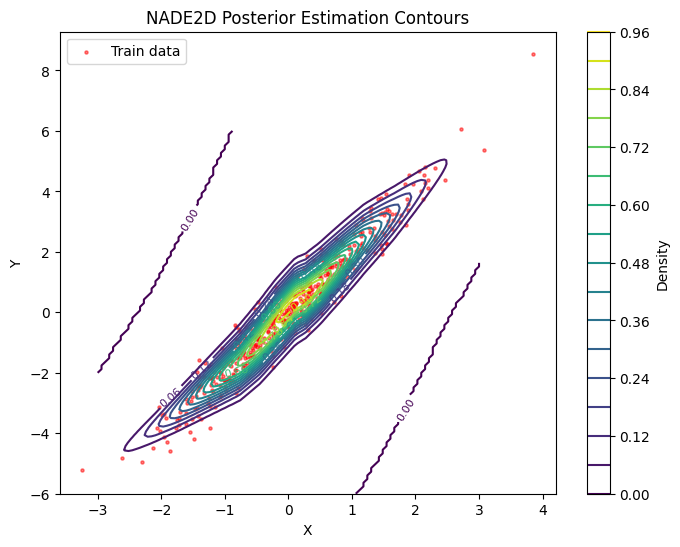

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

class ContinuousNADE2D(nn.Module):
    """
    A continuous NADE for 2D data with Gaussian conditionals:
        p(x0) ~ N(mu0, var0)
        p(x1|x0) ~ N(mu1, var1)

    Dimension order: x0 first, x1 second.
    """
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.input_dim = 2
        self.hidden_dim = hidden_dim

        # Parameters for updating hidden state with x_i
        self._in_W = nn.Parameter(torch.zeros(hidden_dim, self.input_dim))
        self._in_b = nn.Parameter(torch.zeros(hidden_dim,))

        # Each dimension i in [0,1] -> 2 outputs: [mu_i, logvar_i]
        # So total outputs = 2 * input_dim = 4
        self._h_W = nn.Parameter(torch.zeros(2 * self.input_dim, hidden_dim))
        self._h_b = nn.Parameter(torch.zeros(2 * self.input_dim,))

        # Initialize weights
        nn.init.kaiming_normal_(self._in_W)
        nn.init.kaiming_normal_(self._h_W)

    def _forward(self, x):
        """
        Autoregressive forward pass over x's 2 dimensions.
        x: shape (batch_size, 2)
        
        Returns:
          means:   [mu0, mu1], each shape (batch_size,)
          logvars: [lv0, lv1], each shape (batch_size,)
        """
        batch_size = x.shape[0]
        # Hidden pre-activation: start from bias only
        a = self._in_b.expand(batch_size, -1)  # (batch_size, hidden_dim)

        means, logvars = [], []
        for i in range(self.input_dim):
            # Hidden activation
            h = torch.relu(a)  # (batch_size, hidden_dim)

            # We produce [mu_i, logvar_i] from rows 2*i:2*i+2 of _h_W, _h_b
            param_i = h @ self._h_W[2*i:2*i+2, :].t() + self._h_b[2*i:2*i+2]
            # (batch_size, 2)
            mu_i = param_i[:, 0]
            lv_i = param_i[:, 1]

            means.append(mu_i)
            logvars.append(lv_i)

            # Update hidden pre-activation 'a' using x_i
            x_i = x[:, i : i+1]  # (batch_size, 1)
            # a += x_i * W^T
            a = a + x_i @ self._in_W[:, i:i+1].t()

        return means, logvars

    def log_prob(self, x):
        """
        Returns log p(x) for each sample in the batch (shape (batch_size,)).
        p(x) = p(x0) * p(x1|x0) => sum of log p(x_i|x_{<i}).
        """
        means, logvars = self._forward(x)
        logp = 0.0

        for i in range(self.input_dim):
            mu_i = means[i]
            lv_i = logvars[i]  # log variance
            x_i = x[:, i]

            # Gaussian log-prob for dimension i
            # log p_i = -0.5 * [ log(2*pi) + lv + (x_i - mu_i)^2 / exp(lv) ]
            logp_i = -0.5 * (
                torch.log(torch.tensor(2.0 * np.pi)) 
                + lv_i 
                + (x_i - mu_i)**2 / torch.exp(lv_i)
            )
            logp = logp + logp_i

        return logp  # shape (batch_size,)

    def forward(self, x):
        """
        For training, returns mean log-prob across the batch.
        """
        return self.log_prob(x).mean()


class RobustScaledContinuousNADE2D:
    """
    Wraps the ContinuousNADE2D for 2D data using a RobustScaler.
    Provides train() & evaluate() methods, plus a helper for contour plotting.
    """
    def __init__(self, X, Y, hidden_dim=16):
        """
        1) Fit a RobustScaler on (X, Y).
        2) Instantiate the ContinuousNADE2D model.
        """
        # Convert X, Y to numpy arrays
        X = np.array(X).reshape(-1, 1)
        Y = np.array(Y).reshape(-1, 1)
        data_2d = np.hstack([X, Y])  # shape (N, 2)

        # Fit the RobustScaler
        self.scaler = RobustScaler()
        scaled_data_2d = self.scaler.fit_transform(data_2d)

        # Store scaled data as torch tensor
        self.data_torch = torch.FloatTensor(scaled_data_2d)

        # Create NADE model
        self.model = ContinuousNADE2D(hidden_dim=hidden_dim)

    def train(self, epochs=50, batch_size=32, lr=1e-3):
        """
        Train by maximizing log p(x).
        """
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        dataset_size = len(self.data_torch)
        indices = np.arange(dataset_size)

        for epoch in range(epochs):
            np.random.shuffle(indices)
            total_nll = 0.0

            for start_idx in range(0, dataset_size, batch_size):
                end_idx = start_idx + batch_size
                batch_inds = indices[start_idx:end_idx]

                x_batch = self.data_torch[batch_inds]

                optimizer.zero_grad()
                avg_logprob = self.model.forward(x_batch)  # mean over batch
                loss = -avg_logprob  # we want to maximize log prob
                loss.backward()
                optimizer.step()

                total_nll += loss.item() * len(batch_inds)

            avg_nll = total_nll / dataset_size
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, NLL: {avg_nll:.4f}")

    @torch.no_grad()
    def evaluate(self, x_val, y_val):
        """
        Given (x_val, y_val), returns the model's density p(x_val, y_val).
        """
        arr_2d = np.array([[x_val, y_val]], dtype=np.float32)  # shape (1,2)
        scaled_2d = self.scaler.transform(arr_2d)              # shape (1,2)
        x_torch = torch.FloatTensor(scaled_2d)

        log_p = self.model.log_prob(x_torch)  # shape (1,)
        p = torch.exp(log_p)
        return p.item()

    @torch.no_grad()
    def plot_density_contours(self, X_data, Y_data, 
                              xlim=None, ylim=None, 
                              grid_size=100):
        """
        Creates a contour plot of the estimated density over a 2D region.
        Overlays the original training data as scatter points.
        
        Args:
          X_data, Y_data: the original, unscaled training data (for plotting).
          xlim, ylim: tuples (xmin, xmax) and (ymin, ymax) for the plot range.
          grid_size: number of points along each axis in the grid.
        """
        if xlim is None:
            xlim = (X_data.min() - 1.0, X_data.max() + 1.0)
        if ylim is None:
            ylim = (Y_data.min() - 1.0, Y_data.max() + 1.0)

        x_lin = np.linspace(xlim[0], xlim[1], grid_size)
        y_lin = np.linspace(ylim[0], ylim[1], grid_size)
        XX, YY = np.meshgrid(x_lin, y_lin)

        Z = np.zeros_like(XX)
        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                Z[i, j] = self.evaluate(XX[i, j], YY[i, j])

        plt.figure(figsize=(8, 6))
        plt.scatter(X_data, Y_data, s=5, alpha=0.5, c='r', label="Train data")
        cs = plt.contour(XX, YY, Z, levels=15, cmap="viridis")
        plt.clabel(cs, inline=True, fontsize=8)
        plt.colorbar(label="Density")
        plt.title("NADE2D Posterior Estimation Contours")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()


# -------------------------------------------------------------------
# Example usage
# -------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Generate some synthetic 2D data (X ~ Normal(0,1); Y=2X + noise)
    np.random.seed(42)
    N = 500
    X_data = np.random.normal(0, 1, size=N)
    Y_data = 2.0 * X_data + np.random.normal(0, 0.5, size=N)

    # 2) Build and train the NADE
    nade2d = RobustScaledContinuousNADE2D(X_data, Y_data, hidden_dim=16)
    nade2d.train(epochs=50, batch_size=32, lr=1e-3)

    # 3) Evaluate p(x=0.5, y=1.0)
    p_val = nade2d.evaluate(0.5, 1.0)
    print(f"p(x=0.5, y=1.0) = {p_val:.6f}")

    # 4) Plot contours of the learned density, overlaid on training data
    nade2d.plot_density_contours(X_data, Y_data, 
                                 xlim=(-3, 3),  # e.g. or use None
                                 ylim=(-6, 6),  # e.g. or use None
                                 grid_size=100)


In [52]:
# now with actual CMD data from speedystar without extinction and errors
import pandas as pd
import sys
from astropy.table import Table
# load the data
speedystar_catalog = pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_no_extinction.csv')

In [32]:
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')  # Add scripts folder to path
from scripts.implied_d_vr import *  # Import specific functions or classes as needed
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.catalog_preparation.prepare_gaia import *
from scripts.misc.fft_kde import WeightedFFTKDE

In [53]:
speedystar_ready = prepare_speedystar(Table.from_pandas(speedystar_catalog))

/Users/mncavieres/opt/anaconda3/envs/speedystartest/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
X_data = speedystar_catalog['Gaia_BP'] - speedystar_catalog['Gaia_RP']
Y_data = speedystar_catalog['Gaia_G'] -5*np.log10(speedystar_catalog.dist*1000) +5

In [39]:
# # extract the data
# X_data = speedystar_ready['bp_rp'].values
# Y_data = speedystar_ready['implied_M_g'] # note that for either we use the extinction corrected values as simulation does not include extinction


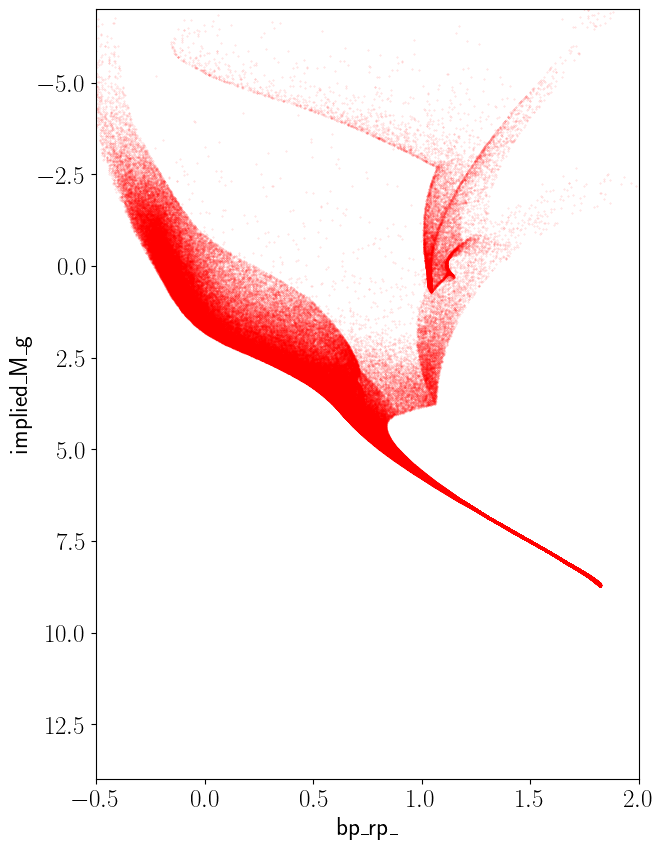

In [64]:
plt.figure(figsize=(7, 10))
plt.scatter(speedystar_catalog['Gaia_BP'] - speedystar_catalog['Gaia_RP'], 
            speedystar_catalog['Gaia_G'] -5*np.log10(speedystar_catalog.dist*1000) +5, s=0.1, 
            alpha=0.2, c='r', label="Train data")
plt.xlabel('bp_rp_')
plt.ylabel('implied_M_g')
plt.ylim(14, -7)
plt.xlim(-0.5, 2)  
plt.show()

Epoch 10/50, NLL: nan
Epoch 20/50, NLL: nan
Epoch 30/50, NLL: nan
Epoch 40/50, NLL: nan
Epoch 50/50, NLL: nan
p(x=0.5, y=1.0) = nan


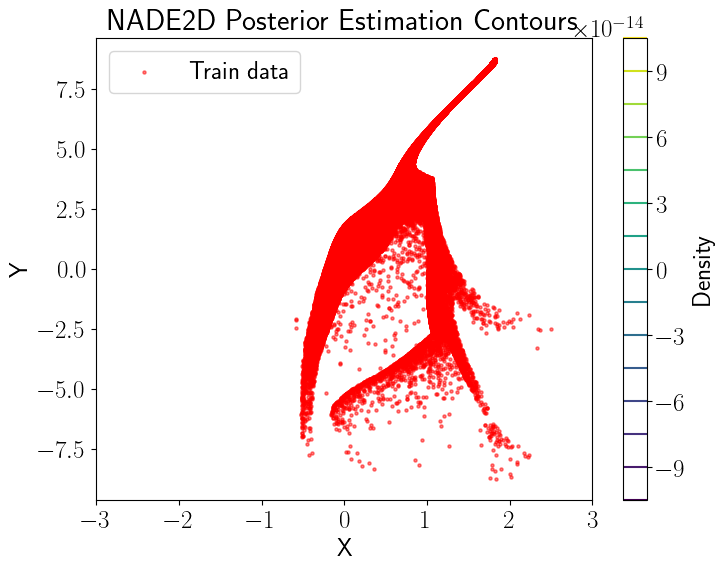

In [67]:
# 2) Build and train the NADE
nade2d = RobustScaledContinuousNADE2D(X_data, Y_data, hidden_dim=16)
nade2d.train(epochs=50, batch_size=32, lr=1e-3)

# 3) Evaluate p(x=0.5, y=1.0)
p_val = nade2d.evaluate(0.5, 1.0)
print(f"p(x=0.5, y=1.0) = {p_val:.6f}")

